<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Fire_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fire Segmentation**

In [1]:
#https://www.kaggle.com/datasets/killa92/fire-segmentation-dataset

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/killa92/fire-segmentation-dataset/fire-segmentation-dataset.zip

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
image_dir = "/content/fire/images/fire"
mask_dir = "/content/fire/masks"

print(len(os.listdir(image_dir)))
print(len(os.listdir(mask_dir)))

27460
27460


In [6]:
val_splits = int(27460 * 0.8)

train_img_paths = sorted(os.path.join(image_dir, i) for i in os.listdir(image_dir))[: val_splits]
train_mask_paths = sorted(os.path.join(mask_dir, i) for i in os.listdir(mask_dir))[: val_splits]

val_img_paths = sorted(os.path.join(image_dir, i) for i in os.listdir(image_dir))[val_splits :]
val_mask_paths = sorted(os.path.join(mask_dir, i) for i in os.listdir(mask_dir))[val_splits :]

print(train_img_paths[1], train_mask_paths[1])

/content/fire/images/fire/Img_1.jpg /content/fire/masks/Img_1.jpg


In [7]:
def read_image(image_path, mask=False, img_size = 256):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)

        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[img_size, img_size])

    else:
        image = tf.image.decode_png(image, channels=3)

        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[img_size, img_size])

    return image / 255.0

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 32, drop_remainder=True)
    return dataset

In [8]:
train_dataset = data_generator(train_img_paths, train_mask_paths)
val_dataset = data_generator(val_img_paths, val_mask_paths)

In [9]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None))>

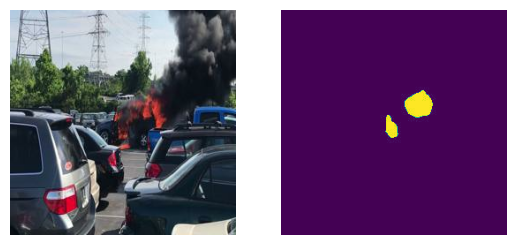

In [10]:
for img, mask in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow((img[20] * 255.0).numpy().astype("uint8"))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow((mask[20] * 255.0).numpy().astype("uint8"))
    plt.axis("off")

plt.show()

In [11]:
def conv_block(inputs, filters, kernel_size = 3, BatchNorm = True):
    x = layers.Conv2D(filters, kernel_size = kernel_size, padding = "same", kernel_initializer = "he_normal")(inputs)

    if BatchNorm:
        x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, kernel_size = kernel_size, padding = "same", kernel_initializer = "he_normal")(x)

    if BatchNorm:
        x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)

    return x

In [12]:
def unet_model(inputs, filters = 16, dropout_rate = 0.1, BatchNorm = True):
    c1 = conv_block(inputs, filters * 1, kernel_size = 3, BatchNorm = BatchNorm)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = conv_block(p1, filters * 2, kernel_size = 3, BatchNorm = BatchNorm)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = conv_block(p2, filters * 4, kernel_size = 3, BatchNorm = BatchNorm)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    c4 = conv_block(p3, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout_rate)(p4)

    c5 = conv_block(p4, filters * 16, kernel_size = 3, BatchNorm = BatchNorm)


    u4 = layers.Conv2DTranspose(filters * 8, kernel_size = 3, strides = 2, padding = "same")(c5)
    u4 = layers.concatenate([u4, c4])
    u4 = layers.Dropout(dropout_rate)(u4)
    u4 = conv_block(u4, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)

    u3 = layers.Conv2DTranspose(filters * 4, kernel_size = 3, strides = 2, padding = "same")(u4)
    u3 = layers.concatenate([u3, c3])
    u3 = layers.Dropout(dropout_rate)(u3)
    u3 = conv_block(u3, filters * 4, kernel_size = 3, BatchNorm = BatchNorm)

    u2 = layers.Conv2DTranspose(filters * 2, kernel_size = 3, strides = 2, padding = "same")(u3)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Dropout(dropout_rate)(u2)
    u2 = conv_block(u2, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)

    u1 = layers.Conv2DTranspose(filters * 1, kernel_size = 3, strides = 2, padding = "same")(u2)
    u1 = layers.concatenate([u1, c1])
    u1 = layers.Dropout(dropout_rate)(u1)
    u1 = conv_block(u1, filters * 1, kernel_size = 3, BatchNorm = BatchNorm)

    outputs = layers.Conv2D(1, kernel_size = 1, activation = "sigmoid")(u1)

    model = keras.Model(inputs, outputs)

    return model

In [13]:
inputs = keras.Input(shape = (256, 256, 3))

unet = unet_model(inputs, dropout_rate = 0.07)

In [14]:
unet.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

In [15]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5)

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience = 3)

callbacks = [reduce_lr, early_stopping]

In [17]:
hist = unet.fit(train_dataset, validation_data = val_dataset, epochs = 5, callbacks = callbacks)

Epoch 1/5
686/686 [==============================] - 500s 729ms/step - loss: 0.0874 - accuracy: 0.9766 - val_loss: 0.0572 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 2/5
686/686 [==============================] - 481s 701ms/step - loss: 0.0421 - accuracy: 0.9783 - val_loss: 0.0488 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 3/5
686/686 [==============================] - 499s 727ms/step - loss: 0.0368 - accuracy: 0.9789 - val_loss: 0.0359 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 4/5
686/686 [==============================] - 499s 727ms/step - loss: 0.0342 - accuracy: 0.9795 - val_loss: 0.0289 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 5/5
686/686 [==============================] - 498s 727ms/step - loss: 0.0325 - accuracy: 0.9799 - val_loss: 0.0304 - val_accuracy: 0.9821 - lr: 0.0010


In [43]:
def pred_mask(dataset, model, shape = 256):
    for img, mask in dataset.take(1):
        img = img[0:16]
        mask = mask[0:16]

        img = np.array(img)
        pred = model.predict(img)

    return pred, img, mask



def plot_mask(img, pred_mask, mask):
    plt.figure(figsize=(10, 10))

    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')
    plt.axis("off")


    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('actual Mask')
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')
    plt.axis("off")

1/1 [==============================] - 0s 29ms/step


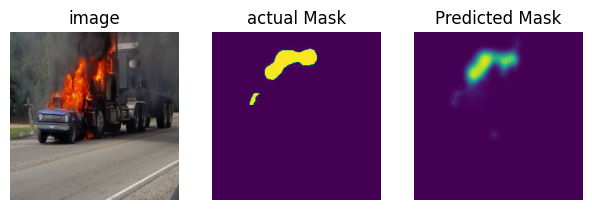

In [33]:
pred_mask, img, mask = pred_mask(val_dataset, unet)
plot_mask(img[12], pred_mask[12][:, :, 0], mask[12])

1/1 [==============================] - 0s 29ms/step


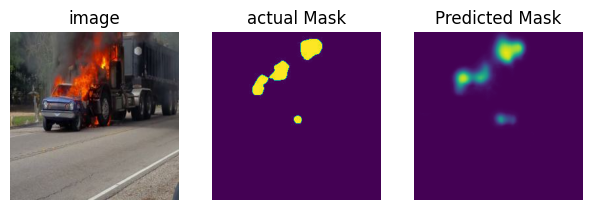

In [39]:
pred_mask, img, mask = pred_mask(val_dataset, unet)
plot_mask(img[15], pred_mask[15][:, :, 0], mask[15])

1/1 [==============================] - 0s 29ms/step


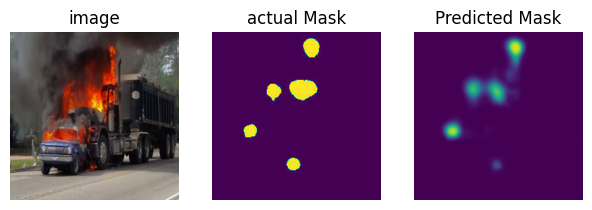

In [44]:
pred_mask, img, mask = pred_mask(val_dataset, unet)
plot_mask(img[1], pred_mask[1][:, :, 0], mask[1])